# Causal Inference with CEM and Weighted Regression

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from cem.match import match
from cem.coarsen import coarsen
from cem.imbalance import L1
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [3]:
uri = os.environ["MONGODB_URI"]
client = MongoClient(uri, server_api=ServerApi("1"))
client.admin.command("ping")
db = client["real-estate"]
collection = db["listings"]

In [4]:
since = datetime.now() - timedelta(days=60)

pipeline = [
        {
            "$match": {"rental": True, "datetime": {"$gte": since}, "bed": {"$lte": 4}},
        },
    ]

results = collection.aggregate(pipeline)

df = pd.DataFrame.from_records(results).set_index("_id")
df.head()

,datetime,provider,rental,price,address,suburb,state,postcode,council,bed,bath,parking,area,dwelling,version
_id,,,,,,,,,,,,,,,
listing-16678011,2023-09-30,domain,True,600,"Tennyson Avenue, Plympton Park, Adelaide, City...",plympton park,sa,5038,city of marion,3,1,2,NaN,house,0.1.0
listing-16677999,2023-09-30,domain,True,480,"Pierson Street, Campbelltown City Council, Ade...",hectorville,sa,5073,city of campbelltown,3,1,2,NaN,house,0.1.0
listing-16677966,2023-09-30,domain,True,595,"Waikiki Court, West Lakes, Adelaide, City of C...",west lakes,sa,5021,city of charles sturt,3,1,2,NaN,house,0.1.0
listing-16031454,2023-09-30,domain,True,550,"Charlbury Road, Medindie Gardens, Adelaide, Ci...",medindie gardens,sa,5081,city of prospect,2,1,1,NaN,duplex,0.1.0
listing-16677589,2023-09-30,domain,True,650,"Orsmond Street, Hindmarsh, Adelaide, City of C...",hindmarsh,sa,5007,city of charles sturt,3,2,1,NaN,house,0.1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, listing-16678011 to listing-16704985
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  950 non-null    datetime64[ns]
 1   provider  950 non-null    object        
 2   rental    950 non-null    bool          
 3   price     950 non-null    int64         
 4   address   950 non-null    object        
 5   suburb    950 non-null    object        
 6   state     950 non-null    object        
 7   postcode  950 non-null    object        
 8   council   950 non-null    object        
 9   bed       950 non-null    int64         
 10  bath      950 non-null    int64         
 11  parking   950 non-null    int64         
 12  area      101 non-null    float64       
 13  dwelling  950 non-null    object        
 14  version   950 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(8)
memory usage: 112.3+ K

In [6]:
df.describe()

,datetime,price,bed,bath,parking,area
count,950,950.000000,950.000000,950.000000,950.000000,101.000000
mean,2023-10-11 04:16:10.105263104,566.391579,2.790526,1.435789,1.717895,496.089109
min,2023-09-30 00:00:00,195.000000,1.000000,1.000000,0.000000,71.000000
25%,2023-10-04 00:00:00,465.000000,2.000000,1.000000,1.000000,340.000000
50%,2023-10-15 00:00:00,550.000000,3.000000,1.000000,2.000000,450.000000
75%,2023-10-16 00:00:00,630.000000,3.000000,2.000000,2.000000,690.000000
max,2023-10-19 00:00:00,2000.000000,4.000000,3.000000,8.000000,990.000000
std,NaN,178.345795,0.777255,0.536922,1.131220,214.446362


In [7]:
df[["bed", "bath", "parking"]].cov()

,bed,bath,parking
bed,0.604125,0.193595,0.391845
bath,0.193595,0.288286,0.099886
parking,0.391845,0.099886,1.279658


In [8]:
df["council"].value_counts()

council
city of charles sturt                                     103
city of port adelaide enfield                             101
city of playford                                           88
city of salisbury                                          83
corporation of the city of adelaide                        62
city of onkaparinga                                        59
city of marion                                             58
corporation of the city of unley                           47
city of norwood payneham & st peters                       44
city of west torrens                                       43
city of campbelltown                                       42
city of tea tree gully                                     37
city of burnside                                           35
mount barker district council                              27
city of holdfast bay                                       26
city of mitcham                                            24


In [12]:
councils = {
    "city of playford": "north",
    "city of port adelaide enfield": "north",
    "city of charles sturt": "west",
    "city of salisbury": "north",
    "corporation of the city of adelaide": "inner",
    "corporation of the city of unley": "inner",
    "city of marion": "south",
    "city of onkaparinga": "south",
    "city of campelltown": "east",
    "city of norwood payneham & st peters": "inner",
    "city of west torrens": "west",
    "city of tea tree gully": "north",
    "city of burnside": "east",
    "city of holdfast bay": "west",
    "mount barker district council": "hills",
    "city of prospect & city of port adelaide enfield": "north",
    "corporation of the town of walkerville": "inner",
    "city of mitcham": "south",
    "city of prospect": "inner",
    "adelaide hills council": "hills",
    "town of gawler": "outer",
    "the barossa council": "outer",
    "city of port adelaide enfield & city of tea tree gully": "north",
    "mid murray council": "outer"
}

In [13]:
assert df.council.nunique() == len(councils)

In [14]:
y = df["price"]
X = df.drop(columns="price")[["bed", "bath", "parking", "council", "dwelling", "area"]]

In [15]:
# no matching
L1(X, "bed")
# very imbalanced

/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2


,bed_level_a,bed_level_b,imbalance
0,1,2,NaN
1,1,3,NaN
2,1,4,NaN
3,2,3,1.0
4,2,4,1.0
5,3,4,1.0


In [16]:
# exact matching
# throw away examples from strata (defined by council, dwelling, bath, parking and area) that do not contain all levels of the treatment (number of beds)
weights = match(X, "bed")

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X, "bed", weights)
# no examples left..

0 observations remain. Threw away 950


/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/match.py:30: UserWarning: No strata had all levels of the treatment variable. All weights will be zero. This usually happens when a continuous variable (including the treatment variable) is not coarsened.
  warnings.warn(
/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2


,bed_level_a,bed_level_b,imbalance
0,1,2,NaN
1,1,3,NaN
2,1,4,NaN
3,2,3,NaN
4,2,4,NaN
5,3,4,NaN


In [17]:
# coarsened exact matching
# throw away examples from strata (defined by COARSENED council, dwelling, bath and parking) that do not contain all levels of the treatment (number of beds)
X_coarse = X.copy()

X_coarse["council"] = X_coarse["council"].map(councils)  # north, south, east, west, inner, hills, outer
X_coarse["parking"] = X_coarse["parking"] > 0  # yes or no
X_coarse["bath"] = pd.cut(X_coarse["bath"], bins=[-1, 1, 2, 100])  # 1, 2, 3+
X_coarse["area"] = pd.cut(X_coarse["area"], bins=[-1, 200, 400, 800, 10000]).cat.add_categories("missing").fillna("missing")

weights = match(X_coarse, "bed")
weights = weights[X.index]  # not necessary, but it supresses that warning

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X_coarse, "bed", weights)

194 observations remain. Threw away 756


,bed_level_a,bed_level_b,imbalance
0,1,2,4.163336e-17
1,1,3,6.591949e-17
2,1,4,0.000000e+00
3,2,3,1.006140e-16
4,2,4,4.163336e-17
5,3,4,6.591949e-17


In [18]:
X_coarse[weights > 0].sort_values(["council", "dwelling", "area", "bath", "parking", "bed"]).head(20)

,bed,bath,parking,council,dwelling,area
_id,,,,,,
listing-16698311,1,"(-1, 1]",True,east,house,missing
listing-16677023,2,"(-1, 1]",True,east,house,missing
listing-16685265,2,"(-1, 1]",True,east,house,missing
listing-16696713,2,"(-1, 1]",True,east,house,missing
listing-16391251,3,"(-1, 1]",True,east,house,missing
listing-16680120,3,"(-1, 1]",True,east,house,missing
listing-15342189,3,"(-1, 1]",True,east,house,missing
listing-16697068,3,"(-1, 1]",True,east,house,missing
listing-16387770,4,"(-1, 1]",True,east,house,missing


In [19]:
print(X_coarse[weights > 0]["dwelling"].value_counts())
print(X_coarse[weights > 0]["council"].value_counts())
print(X_coarse[weights > 0]["parking"].value_counts())
print(X_coarse[weights > 0]["bath"].value_counts())
print(X_coarse[weights > 0]["area"].value_counts())

dwelling
house    194
Name: count, dtype: int64
council
north    100
west      56
inner     29
east       9
Name: count, dtype: int64
parking
True     186
False      8
Name: count, dtype: int64
bath
(-1, 1]     194
(1, 2]        0
(2, 100]      0
Name: count, dtype: int64
area
missing         194
(-1, 200]         0
(200, 400]        0
(400, 800]        0
(800, 10000]      0
Name: count, dtype: int64


In [20]:
# after coarsened matching, there is very little imbalance, so i'm happy not to control for council and dwelling
model = sm.WLS(y, sm.add_constant(X[["bed"]]), weights=weights, hasconst=True)
model.exog_names[:] = ["constant", "bed"]
results = model.fit()

In [21]:
summary = results.summary()
summary

/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.299
Model:                            WLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     404.3
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           3.57e-75
Time:                        06:52:28   Log-Likelihood:                   -inf
No. Observations:                 950   AIC:                               inf
Df Residuals:                     948   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     239.9474     14.135     16.976      0.000     212.208     267.687
bed           98.8725      4.917     20.107      0.000      89.223     108.523
==============================================================================
Omnibus:                      521.272   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20393.910
Skew:                           1.842   Prob(JB):                         0.00
Kurtosis:                      25.397   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
print(summary.as_html())

<table class="simpletable">
<caption>WLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>          <td>price</td>      <th>  R-squared:         </th> <td>   0.299</td>
</tr>
<tr>
  <th>Model:</th>                   <td>WLS</td>       <th>  Adj. R-squared:    </th> <td>   0.298</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   404.3</td>
</tr>
<tr>
  <th>Date:</th>             <td>Fri, 20 Oct 2023</td> <th>  Prob (F-statistic):</th> <td>3.57e-75</td>
</tr>
<tr>
  <th>Time:</th>                 <td>06:52:28</td>     <th>  Log-Likelihood:    </th> <td>    -inf</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>   950</td>      <th>  AIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   948</td>      <th>  BIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     1</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th

In [23]:
# analysis of residuals
residual = results.resid
predicted = results.fittedvalues

<Axes: xlabel='bed', ylabel='None'>

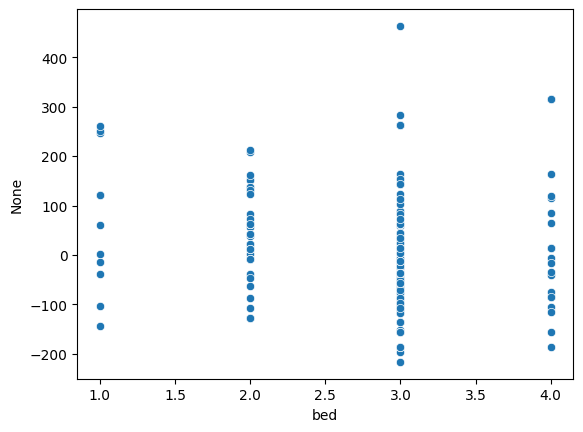

In [24]:
sns.scatterplot(x=X[weights > 0]['bed'], y=results.resid[weights > 0])

In [25]:
# possibly the ignorability assumption is not satisfied
# i.e. there are other confounders that should be taken into account